In [2]:
from scipy.stats import iqr,skew,kurtosis
from datetime import datetime
from copy import deepcopy
import math
from scipy.stats import pearsonr
from sklearn.externals.joblib import Parallel,delayed
import warnings
import pandas as pd
import pickle
import os
import numpy as np
warnings.filterwarnings('ignore')

def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return average, math.sqrt(variance)

def get_rr_features(a):
    return np.array([np.var(a),iqr(a),np.mean(a),np.median(a),np.percentile(a,80),np.percentile(a,20),60000/np.median(a)])


def get_weighted_rr_features(a):
    a = np.repeat(a[:,0],np.int64(np.round(100*a[:,1])))
    return np.array([np.var(a),iqr(a),np.mean(a),np.median(a),np.percentile(a,80),np.percentile(a,20),60000/np.median(a)])

def get_all_features(a):
    try:
        orig = a.shape[0]
        feature_availability = [len(a)]
        feature_qual = [np.median(a[:,1]),np.percentile(a[:,1],80),np.percentile(a[:,1],20),iqr(a[:,1]),np.std(a[:,1]),skew(a[:,1]),kurtosis(a[:,1])]
        feature_activity = [np.median(a[:,2]),np.percentile(a[:,2],80),np.percentile(a[:,2],20),iqr(a[:,2]),np.std(a[:,2]),skew(a[:,2]),kurtosis(a[:,2])]
        a = a[np.where((a[:,0]>300)&(a[:,0]<1500)&(a[:,1]>.15))[0],:]
        if len(a)<3:
            return np.array([0]*30)
        feature_qual+=[np.median(a[:,1]),np.percentile(a[:,1],80),np.percentile(a[:,1],20),iqr(a[:,1]),np.std(a[:,1]),skew(a[:,1]),kurtosis(a[:,1])]
        feature_activity+=[np.median(a[:,2]),np.percentile(a[:,2],80),np.percentile(a[:,2],20),iqr(a[:,2]),np.std(a[:,2]),skew(a[:,2]),kurtosis(a[:,2])]
        feature_availability += [len(a)]
#         print(np.array(feature_activity+feature_availability+feature_qual))
        return np.array(feature_activity+feature_availability+feature_qual)
    except Exception as e:
        print(e)
        return np.array([0]*30)

def get_quality_features(a):
    feature = [np.percentile(a,50),np.mean(a),
               len(a[a>.2])/60,len(a[a>.6])/60]
    return np.array(feature)

def get_daywise(data):
    return [a for i,a in data.groupby(['user','day']) if a[['likelihood_max_array','rr_array']].dropna().shape[0]>120]

def parse_day_data(data_day):
    data_day = data_day.sort_values('ltime').reset_index(drop=True)
    data_day['likelihood_max_array'] = data_day['likelihood_max_array'].apply(lambda a:np.squeeze(a).reshape(-1,3))
    data_day['likelihood'] = data_day['likelihood_max_array'].apply(lambda a:np.max(a,axis=1))
    data_day['likelihood_ind'] = data_day['likelihood_max_array'].apply(lambda a:np.argmax(a,axis=1))
    data_day['rr_array'] = data_day['rr_array'].apply(lambda a:np.squeeze(a).reshape(-1,3))
    data_day['length'] = data_day['rr_array'].apply(lambda a:a.shape[0])
    data_day = data_day[data_day.length>20]
    data_day['time'] = data_day['ltime'].apply(lambda a:datetime.timestamp(a))
    indexes = data_day['likelihood_ind'].values
    rr_arrays = data_day['rr_array'].values
    rrs = []
    for i,rr in enumerate(rr_arrays):
        index = indexes[i]
        frr = np.squeeze(np.array([rr[i,index[i]] for i in range(rr.shape[0])]))
        rrs.append(frr)
    data_day['rr'] = rrs
    data_day['rr_col'] = data_day.apply(lambda a: np.vstack([np.squeeze(a['rr']),np.squeeze(a['likelihood']),np.squeeze(a['activity'])]).T,
                     axis=1)
    data_day['all_features'] = data_day['rr_col'].apply(lambda a: get_all_features(a))
    data_day['all_features_sum'] = data_day['all_features'].apply(lambda a: np.sum(a))
    data_day = data_day[data_day.all_features_sum>0]
    return data_day

def remove_3sd(heart_rate_window):
    temp = deepcopy(heart_rate_window)
    try:
        r,tt = weighted_avg_and_std(heart_rate_window[heart_rate_window[:,1]>.25,0],heart_rate_window[heart_rate_window[:,1]>.25,1])
        index = np.where((heart_rate_window[:,0]<r+3*tt)&(heart_rate_window[:,0]>r-3*tt))[0]
        heart_rate_window = heart_rate_window[index]
    except:
        pass
    if heart_rate_window.shape[0]>10:
        return [heart_rate_window,'Available']
    else:
        return [temp[:10],'Not Available']

    
def parse_for_features(data_day):
    data_day['rr_col'] = data_day['rr_col'].apply(lambda a:a[np.where((a[:,1]>.05)&(a[:,0]>300)&(a[:,0]<1500)&(a[:,2]<.2))[0],:2])
    data_day['rr_col'] = data_day['rr_col'].apply(lambda a:remove_3sd(a))
    data_day['length1'] = data_day['rr_col'].apply(lambda a:a[0].shape[0])
    data_day = data_day[data_day.length1>20]
    data_day['indicator'] = data_day['rr_col'].apply(lambda a:a[1])
    data_day['rr_col'] = data_day['rr_col'].apply(lambda a:a[0])
    data_day['likelihood'] = data_day['rr_col'].apply(lambda a:a[:,1])
    data_day['rr'] = data_day['rr_col'].apply(lambda a:a[:,0])
    data_day['rr_features'] = data_day['rr'].apply(lambda a:get_rr_features(a))
    data_day['rr_weighted_features'] = data_day['rr_col'].apply(lambda a:get_weighted_rr_features(a))
    data_day['quality_features'] = data_day['likelihood'].apply(lambda a:get_quality_features(a))
    data_day['quality_mag'] = data_day['quality_features'].apply(lambda a:np.sum(a)/len(a))
    return data_day

def normalize_daywise(feature_matrix,quals1):
    for i in range(feature_matrix.shape[1]):
        m,s = weighted_avg_and_std(feature_matrix[:,i], quals1)
        feature_matrix[:,i]  = (feature_matrix[:,i] - m)/s
    return feature_matrix


def get_stress(data_day):
    stress_model = pickle.load(open('../models/stress_model_weighted.p','rb'))
    feature_matrix = np.array(list(data_day['rr_weighted_features'].values))
    quals1 = np.array(list(data_day['quality_mag'].values))
    feature_matrix = normalize_daywise(feature_matrix,quals1)
    stress_likelihood = stress_model.predict_proba(feature_matrix)[:,1]
    data_day['stress_likelihood1'] = stress_likelihood
    
    stress_model = pickle.load(open('../models/stress_model_weighted.p','rb'))
    feature_matrix = np.array(list(data_day['rr_weighted_features'].values))
    feature_matrix = normalize_daywise(feature_matrix,[1]*len(quals1))
    stress_likelihood = stress_model.predict_proba(feature_matrix)[:,1]
    data_day['stress_likelihood2'] = stress_likelihood
    return data_day

def get_corr(data_day1):
    if data_day1.shape[0]<60:
        return np.zeros((0,7))
    data_day1['quality_mag_1'] = data_day1['quality_mag'].apply(lambda a:np.round(100*a)/100)
    all_corr = []
    for q in np.unique(data_day1['quality_mag_1'].values):
        tmp = data_day1[data_day1.quality_mag_1>=q]
        tmp2 = tmp[['stress_likelihood_ecg','stress_likelihood','stress_likelihood1','stress_likelihood2']].dropna()
        if tmp2.shape[0]<20:
            continue
        feature = np.array([q,
                   pearsonr(tmp2['stress_likelihood_ecg'].values,tmp2['stress_likelihood'].values)[0],
                   pearsonr(tmp2['stress_likelihood_ecg'].values,tmp2['stress_likelihood1'].values)[0],
                   pearsonr(tmp2['stress_likelihood_ecg'].values,tmp2['stress_likelihood2'].values)[0],
                   pearsonr(tmp2['stress_likelihood'].values,tmp2['stress_likelihood1'].values)[0],
                   tmp['stress_likelihood1'].dropna().shape[0],
                   data_day1['stress_likelihood_ecg'].dropna().shape[0]])
        all_corr.append(feature)
    return np.array(all_corr)

def parse_each_day(a):
    columns = a.columns
    ecg_len = a['stress_likelihood_ecg'].dropna().shape[0]
    a = parse_day_data(a)
    a = parse_for_features(a)
    a = get_stress(a)
    a['quality_mag_1'] = a['quality_mag'].apply(lambda a:np.round(100*a)/100)
    ppg_len = a['stress_likelihood1'].dropna().shape[0]
    a1 = a[['quality_mag_1','stress_likelihood1']].dropna()
    ff = []
    for q in np.unique(a1['quality_mag_1'].values):
        ff.append(np.array([q,a1[a1.quality_mag_1==q].shape[0],ecg_len,ppg_len]))
    all_corr = get_corr(a)
    if all_corr.shape[0]==0:
        return np.zeros((0,7)),np.array(ff).reshape(-1,4),np.zeros((0,3)),a
    tmp2 = a[['stress_likelihood_ecg','stress_likelihood','stress_likelihood1','stress_likelihood2']].dropna()
    try:
        tmp = np.array([pearsonr(tmp2['stress_likelihood_ecg'].values,tmp2['stress_likelihood'].values)[0],
                       pearsonr(tmp2['stress_likelihood_ecg'].values,tmp2['stress_likelihood1'].values)[0],
                       pearsonr(tmp2['stress_likelihood_ecg'].values,tmp2['stress_likelihood2'].values)[0]])
    except:
        return np.zeros((0,7)),np.array(ff).reshape(-1,4),np.zeros((0,3)),a
    if len(tmp[~np.isnan(tmp)])<3:
        return np.zeros((0,7)),np.array(ff).reshape(-1,4),np.zeros((0,3)),a
    else:
        return all_corr,np.array(ff).reshape(-1,4),tmp.reshape(-1,3),a

def parse_each_participant(directory,d):
    data = pickle.load(open(directory+d,'rb')).reset_index(drop=True)
    ema = data[['user','day','window','time','ltime','all_scores','score','label']]
    data = data.drop(['all_scores','score','label'],axis=1)
    data_all = get_daywise(data)
    if len(data_all)==0:
        return np.zeros((0,7)),np.zeros((0,4)),np.zeros((0,3)),0,0
    final_output = [parse_each_day(a) for a in data_all]
    final_qual_corr = np.concatenate([a[0] for a in final_output])
    final_yield = np.concatenate([a[1] for a in final_output])
    final_day_corr = np.concatenate([a[2] for a in final_output])
    user_df = pd.concat([a[3] for a in final_output])
    if user_df.shape[0]<60:
        return np.zeros((0,7)),np.zeros((0,4)),np.zeros((0,3)),0,0
    pickle.dump([user_df,ema],open(directory1+d,'wb'))
    return final_qual_corr,final_yield,final_day_corr,1,len(np.unique(user_df['day'].values))

directory = '../../cc3/rice_data/ecg_ppg_25_left2/'
directory1 = '../../cc3/rice_data/ecg_ppg_25_left3/'
all_data = Parallel(n_jobs=30,verbose=2)(delayed(parse_each_participant)(directory,d) for d in os.listdir(directory) if d[-1]=='p')
# all_data = [parse_each_participant(directory,d) for d in os.listdir(directory)]

[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  29 out of  58 | elapsed:  2.5min remaining:  2.5min
[Parallel(n_jobs=30)]: Done  58 out of  58 | elapsed:  4.9min finished


In [3]:
data1 = np.concatenate([a[0] for a in all_data])
yld = np.concatenate([a[1] for a in all_data])
yld1 = yld[:,:2]
yld = yld[:,2:]
day_corr = np.concatenate([a[2] for a in all_data])

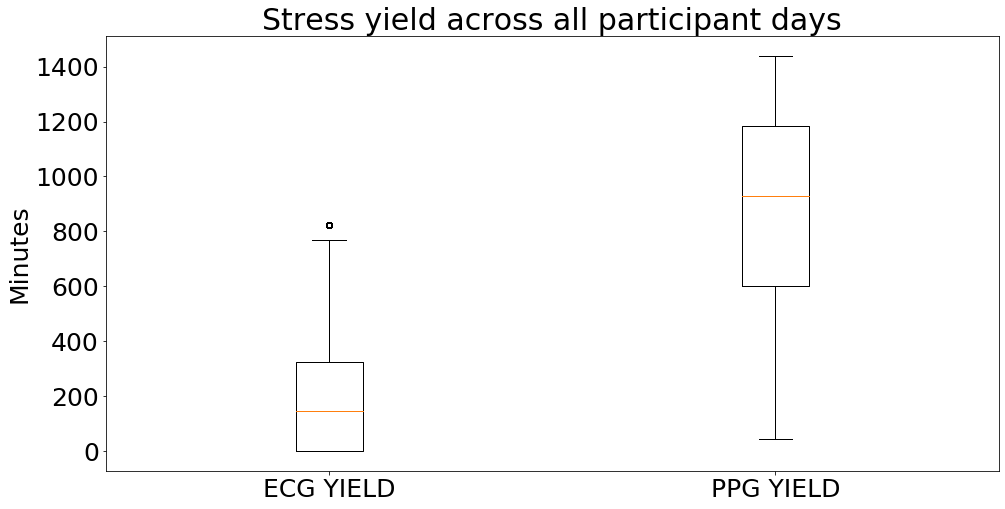

In [4]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':25})
plt.figure(figsize=(16,8))
plt.boxplot(yld)
plt.ylabel('Minutes')
plt.xticks(range(1,yld.shape[1]+1),['ECG YIELD','PPG YIELD'])
plt.title('Stress yield across all participant days')
plt.show()

In [5]:
print(day_corr.shape)
day_corr = day_corr[~np.isnan(day_corr).any(axis=1)]
print(np.sum([a[4] for a in all_data]),'- Participant Days,',np.sum([a[3] for a in all_data]),'- Users')

(420, 3)
675 - Participant Days, 58 - Users


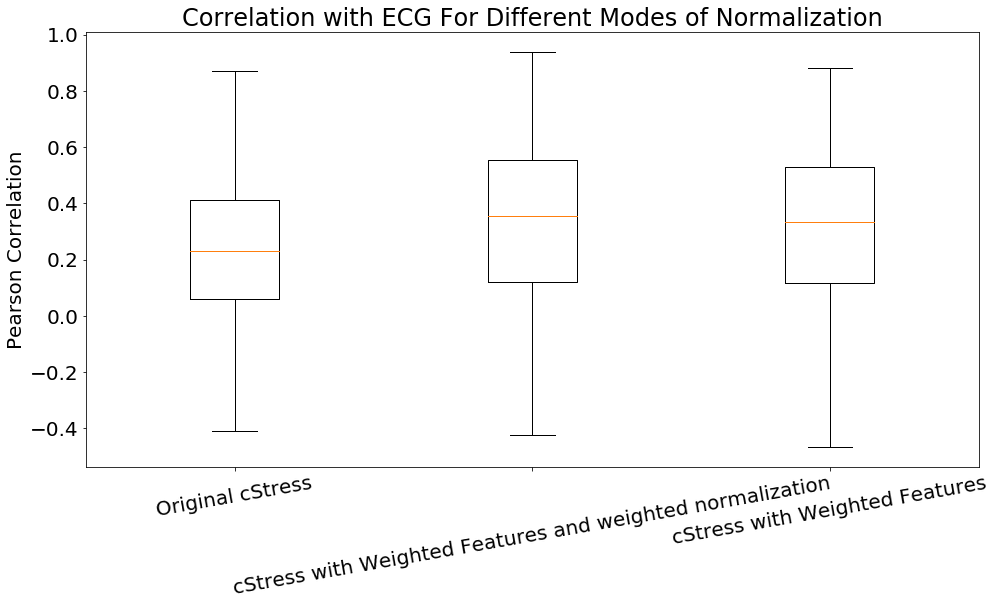

In [6]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(16,8))
plt.boxplot(day_corr[~np.isnan(day_corr).any(axis=1)][:,np.array([0,1,2])])
plt.ylabel('Pearson Correlation')
plt.xticks(range(1,day_corr.shape[1]+1),['Original cStress','cStress with Weighted Features and weighted normalization','cStress with Weighted Features'],rotation=10)
plt.title('Correlation with ECG For Different Modes of Normalization')
plt.show()

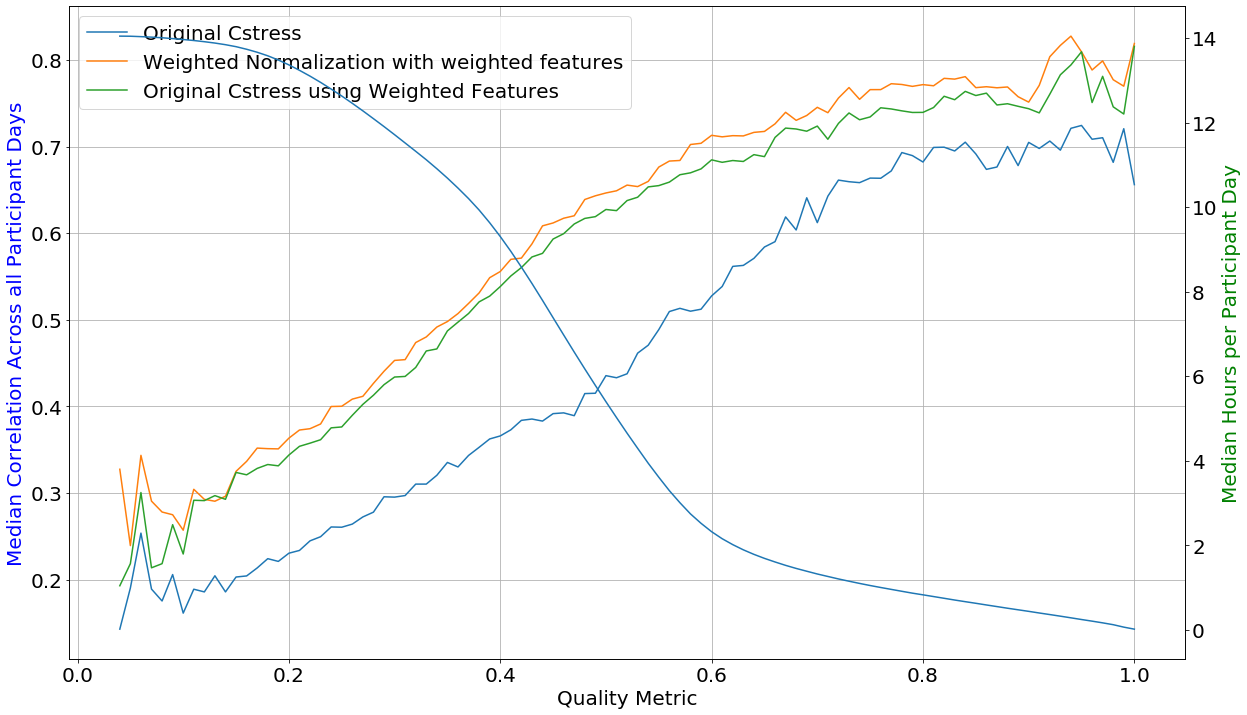

In [7]:
data_all = pd.DataFrame(data1,columns=['quality','corr_orig','corr_new','corr_new1','corr_between','ppg_yield','ecg_yield'])
data_all1 = pd.DataFrame(yld1,columns=['quality','ppg_yield'])

corr_25 = data_all.groupby('quality').quantile(.5)
x = corr_25.index.values
x1 = np.unique(data_all1['quality'].values)
y = []
for a in x1:
    y.append(data_all1[data_all1.quality>=a]['ppg_yield'].sum()/60/np.sum([a[4] for a in all_data]))

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size':20})
fig, ax1 = plt.subplots(figsize=(20,12))
ax2 = ax1.twinx()
ax1.plot(x,corr_25['corr_orig'].loc[x],label='Original Cstress')
ax1.plot(x,corr_25['corr_new'].loc[x],label='Weighted Normalization with weighted features')
ax1.plot(x,corr_25['corr_new1'].loc[x],label='Original Cstress using Weighted Features')
# ax1.plot(x,corr_25['corr_between'].loc[x],label='Original Normalization using auto Features')
ax2.plot(x1,y,label='PPG Yield')
ax1.grid()
# ax1.plot(x,corr_75['corr_orig'].loc[x],label='Original 75th')
# ax1.plot(x,corr_75['corr_new'].loc[x],label='Weighted 75th')
ax1.legend(fontsize=20)
ax1.set_xlabel('Quality Metric')
ax2.set_ylabel('Median Hours per Participant Day', color='g')
ax1.set_ylabel('Median Correlation Across all Participant Days', color='b')
plt.show()


# plt.figure(figsize=(16,8))



(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
        69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
        86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97]),
 <a list of 97 Text xticklabel objects>)

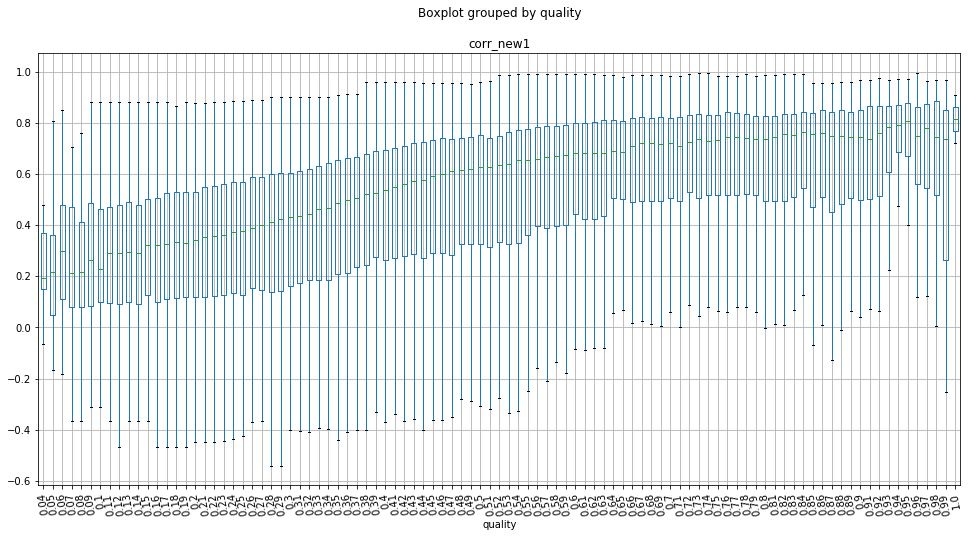

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize=(16,8))
plt.suptitle('')
c = data_all.boxplot(column=['corr_new1'], by='quality', ax=ax,showfliers=False)
plt.xticks(rotation=100)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize=(16,8))
plt.suptitle('')
c = data_all.boxplot(column=['ppg_yield'], by='quality', ax=ax)

In [ ]:
data_all.groupby('quality').quantile([.25,.75]).loc[(0.2, 0.25)]

In [ ]:
import sklearn

In [ ]:
sklearn.show_versions()

In [ ]:
data_all1['quality']